# NCEI comparison with PAG-ASA data

This notebook focuses on the validation of `NCEI` against `PAG-ASA` station data for the **Temperature variables**: `tmean`, `tmax`, `tmin`.

In [1]:
%load_ext autoreload
%autoreload 2

## Set-up and Imports

In [2]:
import geopandas as gpd
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import folium

import json
from loguru import logger
from pathlib import Path

from geowrangler.datasets import geofabrik

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import sys

sys.path.append("../../../")  # include parent directory
from src.vector_utils import *

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
# data directories
DATA_DIR = Path("../../../data/")
SRC_DIR = Path("../../../src/")
ADMIN_FPATH = DATA_DIR / "01-admin-bounds"
RAW_FPATH = DATA_DIR / "02-raw"
PROCESSED_FPATH = DATA_DIR / "03-processed"
OUTPUT_FPATH = DATA_DIR / "04-output"
GIS_FPATH = DATA_DIR / "05-gis"

### Load Admin Bounds 

In [4]:
# Load the administrative boundaries for the 12 cities
admin_bounds_gdf = gpd.read_file(ADMIN_FPATH / "renamed_target_admin_bounds.gpkg")

### Load NCEI

In [5]:
ncei_tmean_df = pd.read_csv(RAW_FPATH / "ncei" / "NCEI_tmean_all_stns.csv")
ncei_tmean_df = ncei_tmean_df.drop(columns=["Unnamed: 0"])
ncei_tmean_df.head(2)

,DATE,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
0,2002-01-01,NaN,NaN,27.4,26.8,NaN,NaN,NaN,25.9,NaN,NaN,24.8,NaN
1,2002-01-02,NaN,NaN,27.9,NaN,NaN,NaN,NaN,26.1,NaN,25.8,NaN,NaN


In [6]:
ncei_tmin_df = pd.read_csv(RAW_FPATH / "ncei" / "NCEI_tmin_all_stns.csv")
ncei_tmin_df = ncei_tmin_df.drop(columns=["Unnamed: 0"])
ncei_tmin_df.head(2)

,DATE,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
0,2002-01-01,NaN,NaN,24.0,23.0,NaN,NaN,NaN,23.0,NaN,NaN,24.0,NaN
1,2002-01-02,NaN,NaN,24.0,NaN,NaN,NaN,NaN,23.0,NaN,23.0,NaN,NaN


In [7]:
ncei_tmax_df = pd.read_csv(RAW_FPATH / "ncei" / "NCEI_tmax_all_stns.csv")
ncei_tmax_df = ncei_tmax_df.drop(columns=["Unnamed: 0"])
ncei_tmax_df.head(2)

,DATE,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
0,2002-01-01,NaN,NaN,31.0,30.1,NaN,NaN,NaN,29.0,NaN,NaN,26.2,NaN
1,2002-01-02,NaN,NaN,31.8,NaN,NaN,NaN,NaN,29.0,NaN,30.3,NaN,NaN


### Load PAG-ASA Station Data

In [40]:
stations_list = [
    "Cabanatuan",
    "Dagupan",
    "Davao City",
    "Dumangas",
    "Legazpi",
    "Lumbia-El Salvador",
    "Mactan",
    "NAIA",
    "Port Area",
    "Science Garden",
    "Tacloban",
    "Zamboanga",
]


def load_pagasa_station_data(stations):
    pagasa_dfs = {}
    for station in stations:
        df = pd.read_csv(RAW_FPATH / "pagasa" / f"{station} Daily Data.csv")
        pagasa_dfs[station] = df
    return pagasa_dfs

In [9]:
PAGASA_DFS = load_pagasa_station_data(stations_list)

In [10]:
PAGASA_DFS["Tacloban"]

,YEAR,MONTH,DAY,RAINFALL,TMAX,TMIN,TMEAN,RH,WIND_SPEED,WIND_DIRECTION
0,2008.0,7.0,1.0,0.2,30.4,25.4,27.90,87.0,1.0,320.0
1,2008.0,7.0,2.0,4.4,31.6,25.2,28.40,92.0,1.0,320.0
2,2008.0,7.0,3.0,3.6,31.0,24.3,27.70,88.0,1.0,160.0
3,2008.0,7.0,4.0,0.0,32.1,25.8,29.00,84.0,1.0,140.0
4,2008.0,7.0,5.0,0.4,32.6,25.8,29.20,84.0,1.0,110.0
...,...,...,...,...,...,...,...,...,...,...
364,2018.0,12.0,27.0,15.2,29.0,22.6,25.80,82.0,2.0,290.0
365,2018.0,12.0,28.0,99.2,26.0,24.0,25.00,96.0,2.0,290.0
366,2018.0,12.0,29.0,0.4,28.8,25.2,27.00,92.0,2.0,270.0
367,2018.0,12.0,30.0,48.8,31.0,24.5,27.75,87.0,2.0,340.0


In [22]:
PAGASA_DFS["Tacloban"][PAGASA_DFS["Tacloban"]["YEAR"] == 2008]

,YEAR,MONTH,DAY,RAINFALL,TMAX,TMIN,TMEAN,RH,WIND_SPEED,WIND_DIRECTION
0,2008.0,7.0,1.0,0.2,30.4,25.4,27.9,87.0,1.0,320.0
1,2008.0,7.0,2.0,4.4,31.6,25.2,28.4,92.0,1.0,320.0
2,2008.0,7.0,3.0,3.6,31.0,24.3,27.7,88.0,1.0,160.0
3,2008.0,7.0,4.0,0.0,32.1,25.8,29.0,84.0,1.0,140.0
4,2008.0,7.0,5.0,0.4,32.6,25.8,29.2,84.0,1.0,110.0
...,...,...,...,...,...,...,...,...,...,...
179,2008.0,12.0,27.0,8.8,31.4,25.0,28.2,87.0,1.0,60.0
180,2008.0,12.0,28.0,0.0,29.0,24.8,26.9,90.0,1.0,320.0
181,2008.0,12.0,29.0,4.4,31.2,25.1,28.2,86.0,1.0,320.0
182,2008.0,12.0,30.0,39.6,28.6,24.2,26.4,91.0,1.0,320.0


### Utils

In [63]:
def plot_histograms(dfs_to_compare, fig_title):
    fig, ax = plt.subplots(figsize=(6, 4))
    for a in dfs_to_compare:
        sns.histplot(
            data=a,
            bins=20,
            ax=ax,
            kde=True,
            multiple="layer",
            legend=True,
        )
    fig.suptitle(fig_title)
    fig.legend(labels=["NCEI", "PAG-ASA"])
    fig.tight_layout()


def plot_tmean_distributions(year, station_name, climate_var):
    # filter ncei
    filter_year_ncei_tmean = ncei_tmean_df[
        (ncei_tmean_df["DATE"].dt.year == year) & (ncei_tmean_df["DATE"].dt.month >= 7)
    ]

    # filter pagasa to a station-year
    pagasa_df = PAGASA_DFS[station_name]
    filter_year_pagasa_df = pagasa_df[pagasa_df["YEAR"] == year]

    ncei_col = ncei_tmean_df.filter(like=station_name.split()[0]).columns

    dfs_to_compare = [
        filter_year_ncei_tmean[ncei_col],
        filter_year_pagasa_df[climate_var],
    ]

    plot_histograms(dfs_to_compare, f"{station_name} {climate_var} Distribution {year}")

In [107]:
def get_error_metrics(year, ncei_df, station_name, climate_var):
    # filter ncei
    ncei_df = ncei_df.copy()
    filter_year_ncei = ncei_df[
        (ncei_df["DATE"].dt.year == year) & (ncei_df["DATE"].dt.month >= 7)
    ]
    ncei_col = ncei_df.filter(like=station_name.split()[0]).columns
    ncei_colname = ncei_col.tolist()[0]
    filter_year_ncei = filter_year_ncei[["DATE", ncei_colname]]
    filter_year_ncei = filter_year_ncei.rename(
        columns={ncei_colname: f"ncei_{climate_var}"}
    )

    # filter pagasa to a station-year
    pagasa_df = PAGASA_DFS[station_name].copy()
    filter_year_pagasa_df = pagasa_df[pagasa_df["YEAR"] == year]
    filter_year_pagasa_df = filter_year_pagasa_df[["DATE", climate_var]]
    # join to one table
    joined_table = filter_year_pagasa_df.merge(filter_year_ncei, how="inner", on="DATE")
    clean_joined = joined_table.dropna(subset=[climate_var, f"ncei_{climate_var}"])

    # prep for error calculations
    y_true = clean_joined[climate_var].tolist()  # pagasa
    y_pred = clean_joined[f"ncei_{climate_var}"].tolist()  # ncei

    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    return mape, mae, rmse

## Quick Sense-checks for NCEI

In [26]:
# tmean
ncei_tmean_df["DATE"].min(), ncei_tmean_df["DATE"].max()

('2002-01-01', '2022-12-31')

In [32]:
ncei_tmean_df.shape[0]

7666

In [27]:
ncei_tmean_df.describe()

,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
count,6071.000000,7616.000000,7666.000000,3302.000000,7606.000000,4379.000000,7634.000000,7662.000000,7548.000000,7242.000000,5498.000000,7644.000000
mean,27.442201,27.718750,28.236721,27.714809,27.671404,26.451701,27.936167,28.169473,28.480644,27.497804,27.585758,28.377852
std,1.636487,1.451777,1.120865,1.353974,1.366773,1.110512,1.180125,1.551549,1.492267,1.625380,1.291821,1.051649
min,21.400000,22.100000,22.400000,23.200000,22.500000,22.300000,22.800000,21.600000,21.200000,20.200000,22.100000,24.300000
25%,26.400000,26.700000,27.600000,26.800000,26.800000,25.700000,27.200000,27.100000,27.475000,26.400000,26.800000,27.800000
50%,27.400000,27.800000,28.400000,27.700000,27.700000,26.400000,28.000000,28.100000,28.500000,27.500000,27.700000,28.500000
75%,28.450000,28.700000,29.000000,28.600000,28.600000,27.200000,28.800000,29.200000,29.500000,28.600000,28.500000,29.100000
max,32.600000,32.500000,32.000000,32.200000,31.500000,30.200000,31.400000,32.900000,33.400000,32.800000,31.700000,31.600000


In [20]:
# tmin
ncei_tmin_df["DATE"].min(), ncei_tmin_df["DATE"].max()

('2002-01-01', '2022-12-31')

In [31]:
ncei_tmin_df.shape[0]

7666

In [28]:
ncei_tmin_df.describe()

,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
count,6071.000000,7616.000000,7666.000000,3302.000000,7605.000000,4379.000000,7634.000000,7662.000000,7548.000000,7242.000000,5498.000000,7644.000000
mean,23.344721,23.542529,24.208114,23.602059,24.474675,22.469765,24.779159,24.809528,25.343071,23.590155,24.716242,23.803519
std,1.700842,1.841956,0.889709,1.076133,1.487545,1.114658,1.074346,1.486176,1.460776,1.750858,1.118503,1.110211
min,10.000000,9.800000,12.400000,14.000000,15.000000,12.700000,15.600000,17.800000,16.100000,12.400000,10.100000,14.000000
25%,22.500000,23.000000,23.800000,23.000000,23.800000,22.000000,24.000000,24.000000,24.500000,22.600000,24.200000,23.300000
50%,23.800000,24.000000,24.000000,23.500000,24.700000,22.500000,24.900000,25.000000,25.400000,24.000000,24.800000,24.000000
75%,24.500000,24.900000,24.900000,24.000000,25.500000,23.000000,25.500000,25.900000,26.300000,24.800000,25.400000,24.500000
max,28.000000,29.200000,27.400000,29.000000,28.000000,27.500000,28.300000,30.000000,31.300000,29.000000,28.200000,27.500000


In [29]:
# tmax
ncei_tmax_df["DATE"].min(), ncei_tmax_df["DATE"].max()

('2002-01-01', '2022-12-31')

In [33]:
ncei_tmax_df.shape[0]

7666

In [30]:
ncei_tmax_df.describe()

,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
count,6071.000000,7616.000000,7666.000000,3302.000000,7605.000000,4379.000000,7634.000000,7662.000000,7548.000000,7242.000000,5498.000000,7644.000000
mean,33.222978,32.158508,32.239721,31.446245,31.018974,31.649692,31.444878,32.080423,31.738725,32.084383,31.242761,32.880782
std,2.441805,2.074814,1.629757,1.965037,1.914239,1.858564,1.588969,2.120211,1.993907,2.162481,1.927079,1.538638
min,23.000000,25.000000,23.100000,25.200000,23.500000,23.200000,24.400000,23.000000,23.100000,22.800000,23.600000,25.000000
25%,31.900000,31.000000,31.400000,30.200000,30.000000,30.800000,30.500000,30.800000,30.400000,30.800000,30.300000,32.000000
50%,33.200000,32.000000,32.400000,31.500000,31.200000,31.800000,31.500000,32.000000,31.800000,32.200000,31.600000,33.000000
75%,34.800000,33.500000,33.200000,32.600000,32.400000,32.800000,32.500000,33.400000,33.000000,33.500000,32.500000,34.000000
max,40.400000,40.800000,39.900000,39.600000,38.800000,40.400000,38.200000,39.000000,39.800000,39.400000,38.600000,39.600000


## Data Prep

In [13]:
# convert columns to date type
ncei_tmean_df["DATE"] = pd.to_datetime(ncei_tmean_df["DATE"])
ncei_tmin_df["DATE"] = pd.to_datetime(ncei_tmin_df["DATE"])
ncei_tmax_df["DATE"] = pd.to_datetime(ncei_tmax_df["DATE"])

In [15]:
ncei_tmean_df[ncei_tmean_df["DATE"].dt.year == 2018]

,DATE,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
5843,2018-01-01,26.8,26.4,26.3,NaN,25.3,NaN,25.7,26.9,26.8,25.2,NaN,28.0
5844,2018-01-02,26.7,26.6,27.8,NaN,24.6,NaN,27.2,26.9,26.8,26.4,NaN,27.5
5845,2018-01-03,26.5,26.3,28.5,NaN,24.8,NaN,27.6,26.6,26.8,26.3,NaN,28.7
5846,2018-01-04,26.6,27.2,26.7,NaN,26.3,NaN,27.7,27.4,27.4,27.1,NaN,28.6
5847,2018-01-05,27.3,27.5,26.7,NaN,26.4,NaN,27.0,28.6,28.1,28.2,NaN,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6203,2018-12-27,28.2,27.6,27.9,NaN,25.7,NaN,27.4,27.7,27.7,27.1,25.0,28.1
6204,2018-12-28,26.0,25.7,28.7,NaN,25.3,NaN,25.6,25.3,26.1,25.4,24.5,28.1
6205,2018-12-29,24.4,24.5,28.4,NaN,25.6,NaN,27.0,24.4,24.8,23.8,27.1,28.2
6206,2018-12-30,25.7,25.4,27.4,NaN,26.7,NaN,27.1,24.4,24.5,24.1,27.7,28.8


In [59]:
# dumangas
# add TMEAN (average of Tmin and Tmax)

dumangas_df = PAGASA_DFS["Dumangas"]
dumangas_df["TMEAN"] = dumangas_df[["TMAX", "TMIN"]].mean(axis=1)

In [103]:
# ADD DATE for stations
for station in stations_list:
    df = PAGASA_DFS[station]
    df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MONTH"], day=df["DAY"]))

## Mean Temperature

### Distributions

In [ ]:
n = len(stations_list)
for i in range(n):
    try:
        plot_tmean_distributions(2018, stations_list[i], "TMEAN")
    except Exception as error:
        logger.exception(f"{error} Occurred at {stations_list[i]}")

### Quick Error Statistics

In [106]:
error_dict = {}

for station in stations_list:
    try:
        error_dict[station] = get_error_metrics(2018, ncei_tmean_df, station, "TMEAN")
    except Exception as error:
        logger.exception(f"{error} Occurred at {station}")

2023-08-02 11:46:51.530 | ERROR    | __main__:<module>:7 - ['ncei_tmean'] Occurred at Cabanatuan
Traceback (most recent call last):

  File "/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x7f288c47a660, file "/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/ipyk...
           └ <function _run_code at 0x7f288c365af0>
  File "/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <module> at 0x7f288c47a660, file "/home/abbymor

In [102]:
errors_df = pd.DataFrame.from_dict(
    error_dict, orient="index", columns=["MAPE", "MAE", "RMSE"]
)
errors_df

,MAPE,MAE,RMSE
Cabanatuan,0.022140,0.622131,0.838690
Dagupan,0.018717,0.523497,0.688092
Davao City,0.029805,0.865217,0.989016
Legazpi,0.018976,0.539344,0.673321
Mactan,0.018602,0.535054,0.656127
NAIA,0.016326,0.463315,0.567927
Port Area,0.011538,0.325410,0.445699
Science Garden,0.015358,0.427596,0.562015
Tacloban,0.023724,0.673077,0.838333
Zamboanga,0.013806,0.392120,0.504935


## EDA

### Investigate Lumbia-El Salvador

      Lumbia-El Salvador
6024                 NaN
6025                 NaN
6026                 NaN
6027                 NaN
6028                 NaN
...                  ...
6203                 NaN
6204                 NaN
6205                 NaN
6206                 NaN
6207                 NaN

[184 rows x 1 columns]
185    28.30
186    28.00
187    27.50
188    27.00
189    28.00
       ...  
364    26.55
365    24.65
366    27.50
367    27.30
368    27.80
Name: TMEAN, Length: 184, dtype: float64


ValueError: `dataset` input should have multiple elements.

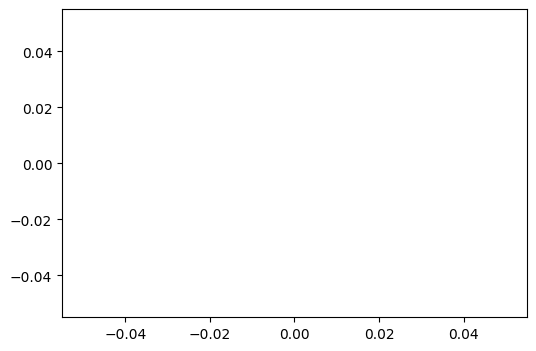

In [55]:
plot_tmean_distributions(2018, "Lumbia-El Salvador", "TMEAN")

In [56]:
filter_year_ncei_tmean = ncei_tmean_df[
    (ncei_tmean_df["DATE"].dt.year == 2018) & (ncei_tmean_df["DATE"].dt.month >= 7)
]
filter_year_ncei_tmean

,DATE,Cabanatuan,Dagupan,Davao Airport,Dumangas,Legazpi,Lumbia-El Salvador,Mactan Airport,NAIA,Port Area,Science Garden,Tacloban,Zamboanga
6024,2018-07-01,28.1,28.2,27.9,NaN,28.1,NaN,28.1,28.0,28.4,28.2,28.4,28.8
6025,2018-07-02,27.6,28.2,27.3,NaN,29.0,NaN,28.3,28.3,28.6,28.8,27.9,28.7
6026,2018-07-03,28.4,29.2,28.2,NaN,29.3,NaN,28.1,28.4,28.7,28.3,26.7,28.3
6027,2018-07-04,27.6,28.3,27.3,NaN,28.7,NaN,28.2,28.4,28.8,28.9,26.6,28.1
6028,2018-07-05,27.7,28.0,26.8,NaN,29.0,NaN,27.4,28.6,28.7,28.7,26.9,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6203,2018-12-27,28.2,27.6,27.9,NaN,25.7,NaN,27.4,27.7,27.7,27.1,25.0,28.1
6204,2018-12-28,26.0,25.7,28.7,NaN,25.3,NaN,25.6,25.3,26.1,25.4,24.5,28.1
6205,2018-12-29,24.4,24.5,28.4,NaN,25.6,NaN,27.0,24.4,24.8,23.8,27.1,28.2
6206,2018-12-30,25.7,25.4,27.4,NaN,26.7,NaN,27.1,24.4,24.5,24.1,27.7,28.8


In [57]:
filter_year_ncei_tmean["Lumbia-El Salvador"].isna().value_counts()

True    184
Name: Lumbia-El Salvador, dtype: int64

In [66]:
filter_year_ncei_tmean["Dumangas"].isna().value_counts()

True    184
Name: Dumangas, dtype: int64